# Lab 4 - Penalized Regression

Dominik Gaweł

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dg7s/Machine-Learning/blob/main/hw/Analyzing_and_Plotting_Bias_in_Penalized_Regression.ipynb)
-------------------------------

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.


## **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.


## MSE decomposition

$\DeclareMathOperator{\EX}{\mathbb{E}}$


\begin{aligned}
MSE &= \EX[(\hat y - y)^2] = \EX[(\hat y -\EX[\hat y]+ \EX[\hat y]- y)^2] \\                        
&= \EX[(\hat y-\EX[\hat y])^2] + (y- \EX[\hat y])^2 + 2\EX[(\hat y -\EX[\hat y])(\EX[\hat y] - y)] \\
&= Var + {Bias}^{2} + \sigma^2,
\end{aligned}
where $\sigma^2$ represents  irreducible noice.

Regularization leads to an optimal trade-off point. Typically for the small **λ** the model capturing all the noise in the training dataset - the model overfits. This leads to low bias but high variance. However, typically for large **λ** the model is too simplisti, cresulting in low variance but high bias  - the model underfits. In both cases, **MSE** is large.

*   Bias **increases** with **lambda**.
*   Variance **decreases** with **lambda**,

Thus, an optimal point exists due to the bias-variance trade-off.

In our case, we can write
\begin{equation}
  \text{Ave}[\text{Bias}]^2 = \text{Ave}[\text{Model Bias}]^2 + \text{Ave}[\text{Estimation Bias}]^2
\end{equation}
\- equation (7.14) of *Elements of Statistcial Learning*.

For linear models, the estimation bias zero. However, for constrained models such as ridge regression, it is positive, and we trade it off with the benefits of a reduced variance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Generating a synthethic dataset

In [2]:
np.random.seed(42)

# Parameters for synthetic data
n_train  = 200
n_test = 5000
n_features = 50
n_non_zero = 5
sigma = 6.0

non_zero_indices = np.random.choice(np.arange(n_features), n_non_zero, replace=False)
beta_true = np.zeros(n_features)
beta_true[non_zero_indices] = np.random.uniform(1, 10, size=n_non_zero)

## λ investigation

In [3]:
def generate_data(n_samples, n_features, beta_true, mean, sigma):
    X = np.random.randn(n_samples, n_features)
    noise = np.random.normal(loc=mean, scale=sigma, size=n_samples)
    y = X.dot(beta_true) + noise
    return X, y

X_test, y_test = generate_data(n_test, n_features, beta_true, 0, sigma)

In [4]:
metrics = {
    'ridge': {'bias2': [], 'variance': [], 'mse': []},
    'lasso': {'bias2': [], 'variance': [], 'mse': []}
}

lambdas = np.logspace(-6, 5, 50)
alphas = lambdas / n_train

n_repeats = 100

for model_type in ['ridge', 'lasso']:
    for alpha in alphas:
        predictions = np.zeros((n_repeats, len(y_test)))

        for rep in range(n_repeats):
            X_train, y_train = generate_data(n_train, n_features, beta_true, 0, sigma)

            if model_type == 'ridge':
                model = Ridge(alpha=alpha, random_state=42)
            else:
                model = Lasso(alpha=alpha, max_iter=10000, random_state=42)

            model.fit(X_train, y_train)
            predictions[rep] = model.predict(X_test)

        mean_pred = np.mean(predictions, axis=0)
        bias2 = np.mean((mean_pred - y_test)**2)
        variance = np.mean(np.var(predictions, axis=0))
        mse = np.mean((predictions - y_test.reshape(1, -1))**2)

        metrics[model_type]['bias2'].append(bias2)
        metrics[model_type]['variance'].append(variance)
        metrics[model_type]['mse'].append(mse)

## Plots

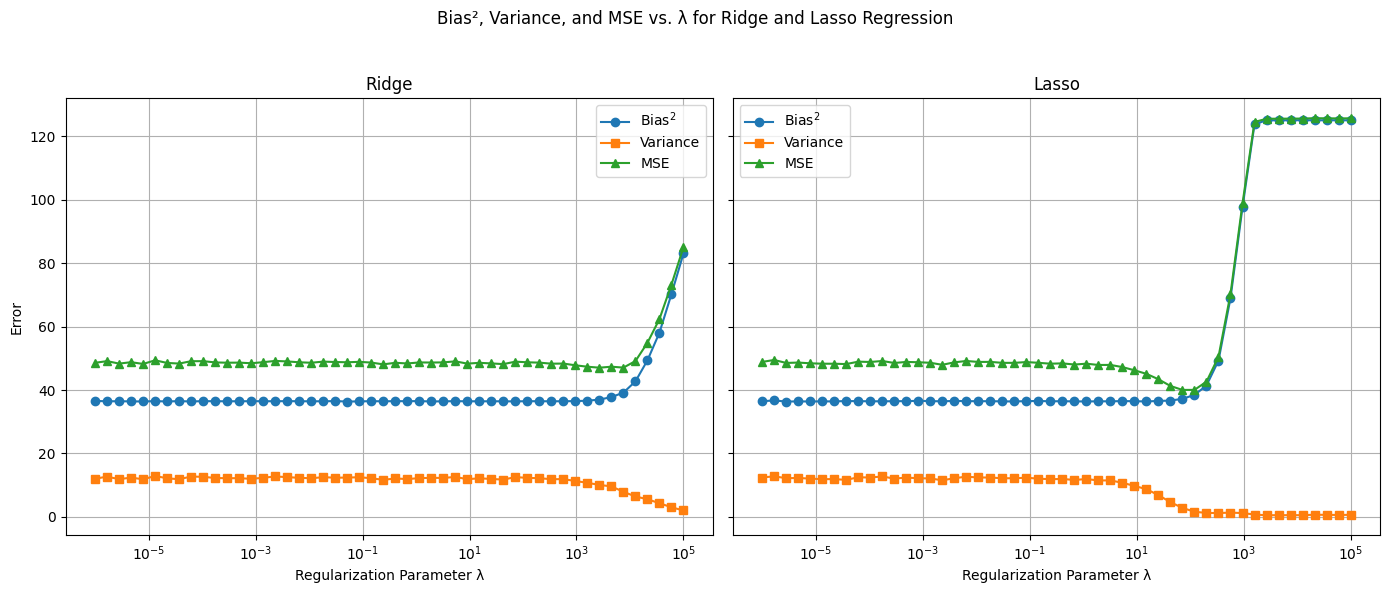

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, model_type in enumerate(['ridge', 'lasso']):
    axes[i].plot(lambdas, metrics[model_type]['bias2'], label='Bias$^2$', marker='o')
    axes[i].plot(lambdas, metrics[model_type]['variance'], label='Variance', marker='s')
    axes[i].plot(lambdas, metrics[model_type]['mse'], label='MSE', marker='^')
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Regularization Parameter λ')
    axes[i].set_title(model_type.capitalize())
    axes[i].legend()
    axes[i].grid(True)

axes[0].set_ylabel('Error')

plt.suptitle('Bias², Variance, and MSE vs. λ for Ridge and Lasso Regression')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Results

In our experiments with the following parameters:  
- **Training set size (n_train):** $200$  
- **Test set size (n_test):** $5000$  
- **Number of features:** $50$  
- **Non-zero coefficients:** $5$
- **Noise level (σ):** $6.0$
- **Regularization (λ):** Geometric scale from $10^{-6}$ to $10^{5}$
- **Repeats:** $100$

we observed the following behavior:

### Observation

- **As λ Increases:**
  - **Ridge Regression:**  
    - **Variance:** Remains high (around $16$) at low λ and then gradually drops toward $0$ as λ exceeds roughly $10^{3}$.  
    - **Bias²:** Starts at about $40$ and increases as variance decreases.  
    - **MSE:** Initially, MSE is around 45. As bias grows, MSE starts increasing, forming a U-shaped curve. However, the curve is less pronounced because variance decreases gradually.
  
  - **Lasso Regression:**  
    - **Variance:** Drops more rapidly between λ values of approximately $10$ and $10^{3}$, reaching nearly $0$ sooner than Ridge.  
    - **Bias²:** Begins around $40$ and increases more sharply in the same range.
    - **MSE:** Exhibits a more pronounced U-shape – as variance decreases quickly, the MSE initially falls, but then the steep increase in bias pushes the MSE upward again.

### Conclusion

Ridge regression uses an L2 penalty that shrinks coefficients uniformly, leading to a gradual bias-variance trade-off. This approach preserves information among correlated predictors, making Ridge preferable when most features contribute and multicollinearity is an issue. Meanwhile, Lasso's L1 penalty induces sparsity by zeroing out less important coefficients, which can sharply increase bias but effectively select features. Therefore, Lasso is more advantageous when the true model is sparse.

